In [ ]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents - Spiral 2B

* [Executive Summary](#Executive-Summary)
* [fc1000 Feature Engineering](fc1000-Feature-Engineering)
* [Base Model](#Base-Model)
* [PCA Based Model](#PCA-Based-Model)
* [High Frequency Classes](#High-Frequency-Classes)
* [High Frequency With PCA](#High-Frequency-with-PCA)
* [Analyze Iterations at High Frequency and PCA](#Analyze-Iterations-at-High-Frequency-and-PCA)
* [Analyze Iterations at High Frequency without PCA](#Analyze-Iterations-at-High-Frequency-without-PCA)
* [Anayze Learning Curve](#Analyze-Learning-Curve)

# Executive Summary _Spiral 2B

Spiral 2B Model Received a Base Model Classification of 55%.  Further investigation nad parameter tuning yielded a higher accuracy of 
- Only looking at the 3 classes with the highest frequency (FBFM1, FBFM5, Urban).
- FBM2 has a high frequency but is suspected to have a lot of mislabels due to significantly high level of misclassification.
- Reducing the number of features from 1000 to 400 via PCA (capturing 98% variance).

Below shows the iterations of the Spiral 2B model along with their 5 fold CV validation scores:

| Model | Score   |
|------|------|
|   Base Model  | 55% |
|   PCA Based Model  | 57% |
|   High Frequency Classes  | 71% |
|   High Frequency with PCA  | 72% |
|   Analyze Iterations at High Frequency without PCA | MemoryError |
|   Alter Iterations at High Frequency and PCA  | MemoryError |

The best results were achieved by NOT using PCA and using the following parameters:
* {'loss': 'hinge', 'penalty': 'l1' or 'None}

# fc1000 Feature Engineering

#### Importing Libraries

In [1]:
# from skicaffe import SkiCaffe
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
%matplotlib inline

In [3]:
import sklearn
sklearn.__version__

'0.18.1'

#### Set Caffe root

The Caffe binary paths are based on the binaries provided by John. The pre-trained ResNet-50 can be found here:
https://github.com/KaimingHe/deep-residual-networks

In [4]:
# caffe_root = '/usr/local/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
# sys.path.insert(0, caffe_root + 'python')
# model_prototxt = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-deploy.prototxt'
# model_trained = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-model.caffemodel'

#### Inception Model

Setting up a Deep Learning model based on ResNet-50 that has been pre-trained on ImageNet data for our Inception Model. Check appropriate layer name here:
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [5]:
# DLmodel = SkiCaffe(caffe_root=caffe_root, 
#                    model_prototxt_path=model_prototxt, 
#                    model_trained_path=model_trained, 
#                    layer_name='fc1000')

#### Feature Engineering

Passing WIFIRE data through the Inception Model for Feature Engineering.

In [6]:
# #Source Path
# src_path = '/home/ssnazrul/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/JPG_Files'

# #Paths
# image_types = ('.jpg')
# image_paths = []
# for root, dirs, files in os.walk(src_path):
#     image_paths.extend([os.path.join(root,f) for f in files if f.endswith(image_types)])
    
# #Labels    
# labels = [os.path.basename(f).split('_')[-1][:-4] for f in image_paths]

# #DataFrame
# df = pd.DataFrame({'Path':image_paths, 'Labels':labels})

In [7]:
# DLmodel.fit()
# image_features = DLmodel.transform(X=df['Path'])

Since processing takes forever, the dataframe and engineered features are stored in csv files.

In [8]:
# root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/"

# #Saving WIFIRE features engineered from Inception Model on csv file
# np.savetxt(root+"WIFIRE_Engineered/WIFIRE_engineered_features.csv", 
#            image_features, 
#            delimiter=",")

In [9]:
# #Saving WIFIRE path and labels to csv
# df.to_csv(root+'WIFIRE_Engineered/WIFIRE_labels.csv')

In [2]:
df_extras = pd.DataFrame.from_csv("./../../WIFIRE/WIFIRE_labels_ElevAspectSlope.csv")[["Slope_WM","Aspect_WM","Elev_WM"]].reset_index( drop=True)
df_extras.head() 

,Slope_WM,Aspect_WM,Elev_WM
0,9.925750,79.746309,165.550253
1,11.804788,71.184017,171.092049
2,2.385194,83.726426,118.241052
3,17.021817,81.384949,129.447622
4,1.075829,0.000000,116.848341


#### Classification

The engineered features are classified using a linear classifier. Based on available memory, the Logistic Classifier calculates the weights either by matrix manipulation or Stochastic Gradient Descent.

In [3]:
root = "./../../WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)
df = pd.read_csv(root+'WIFIRE_labels.csv')
labels = df.Labels.values

In [4]:
print (image_features.shape)
print (df_extras.shape)

(437153, 1000)
(437153, 3)


In [5]:
# Adds slope, aspect, and elev for the entire notebook
image_features = image_features.merge(df_extras,right_index=True, left_index=True).values

In [6]:
print (image_features.shape)

(437153, 1003)


#### Class Distribution

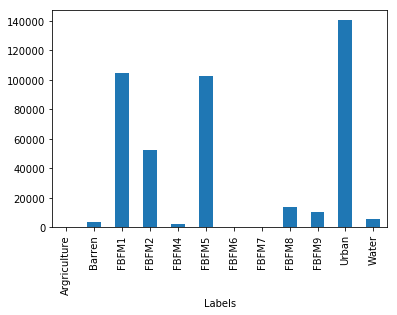

In [7]:
df.groupby('Labels')['Path'].count().plot('bar');

# Base Model

The base model uses SGD's default parameters at 5 fold cross validation.

In [8]:
n_samples = len(df)
X = normalize(image_features)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge',)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'loss': ('hinge',)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [10]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [11]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

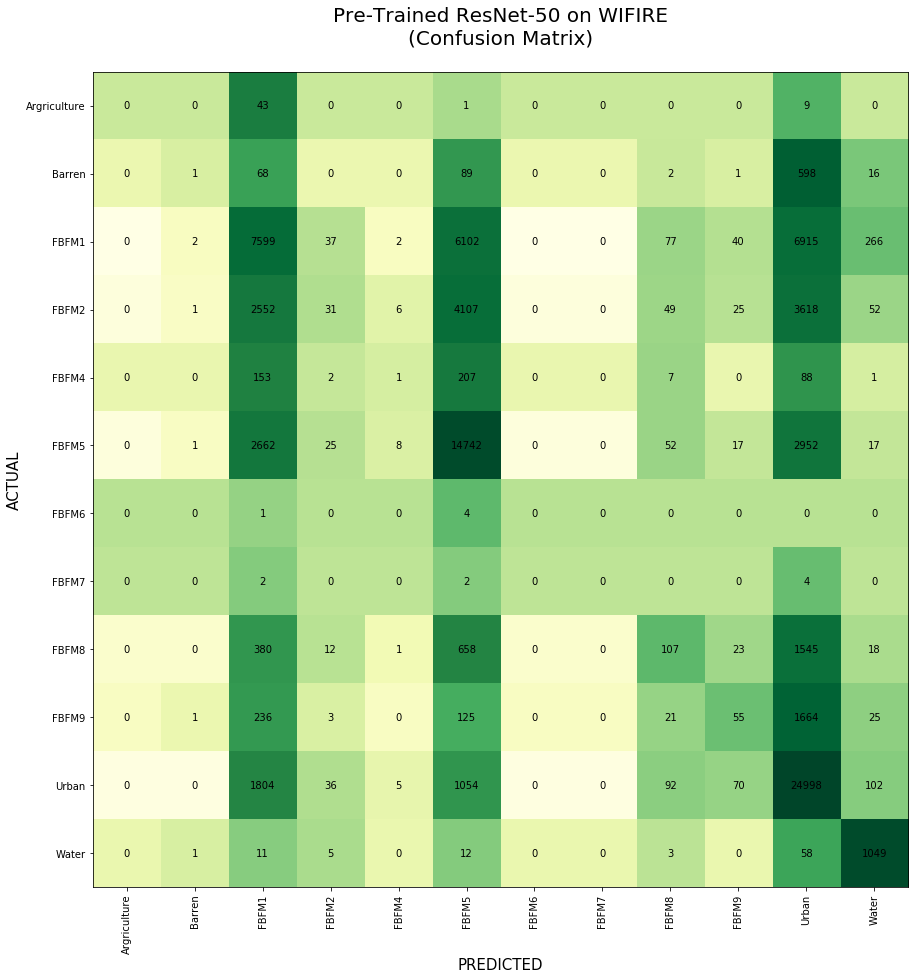

In [12]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

Poor classification achieved. The confusion matrix is very... 

CONFUSING!!! (pun intended.. *badam tiss*)

#### Validation Score

In [13]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

55.567247315025561

# PCA Based Model

#### Original Dimensions

In [14]:
from sklearn.decomposition import PCA

M = normalize(image_features)

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(437153, 1003)

#### Variance Captured by PCA

[ 0.64737341  0.08855648  0.06212944  0.02848602  0.02001168  0.0129934
  0.01004837  0.00888846  0.00611935  0.00563792]


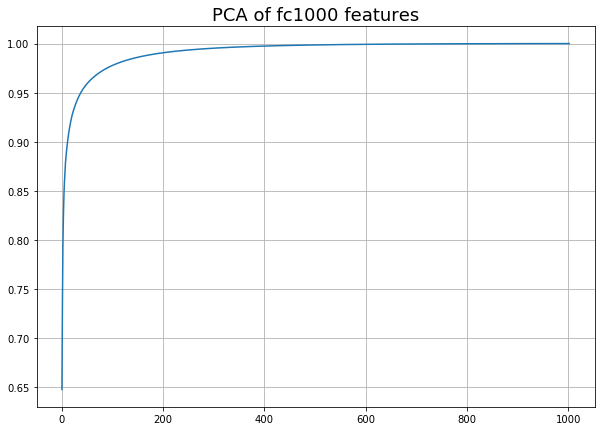

In [15]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [16]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [17]:
n_samples = len(df)
X = normalize(T)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ('hinge', 'log'), 'penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [19]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

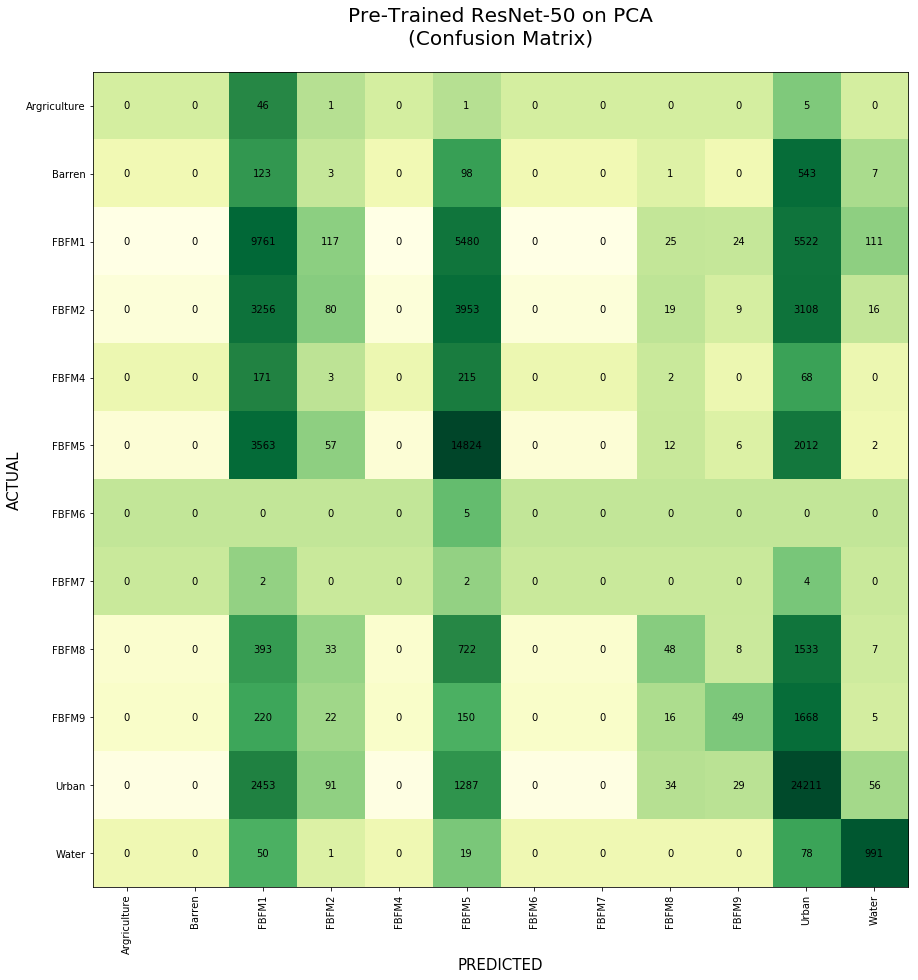

In [20]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Validation Score

In [21]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

57.146778602555159

#### Optimal Parameters

In [22]:
classifier.best_params_

{'loss': 'log', 'penalty': 'l1'}

## High Frequency Classes 

In [23]:
high_dist_class_list = ['FBFM1','FBFM5','Urban']

In [24]:
df_high_class = df[df.Labels.isin(high_dist_class_list)]
high_class_idx = np.array(df_high_class.index)

In [25]:
n_samples = len(df)
X = normalize(image_features[high_class_idx])
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters = {'loss':('log','hinge'),
             'penalty':('l1','l2','none')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ('log', 'hinge'), 'penalty': ('l1', 'l2', 'none')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [28]:
np.unique(y_test)

array(['FBFM1', 'FBFM5', 'Urban'], dtype=object)

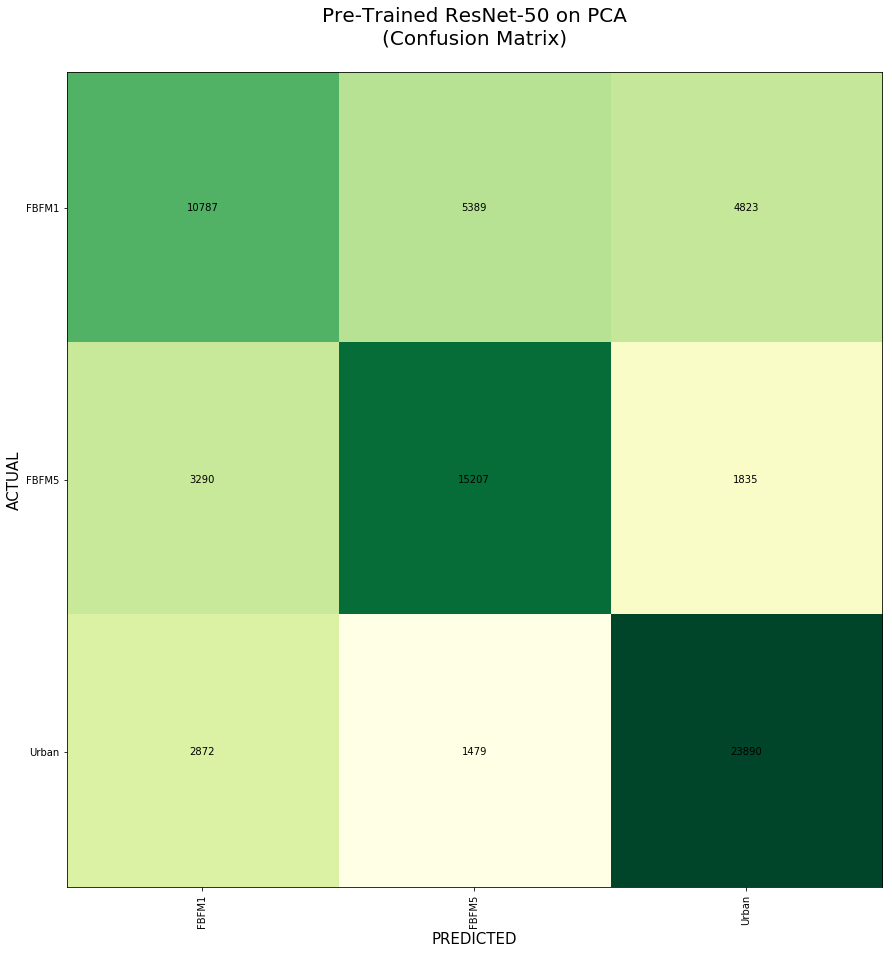

In [29]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Validation Score

In [30]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

71.70125912723509

In [31]:
classifier.best_params_

{'loss': 'hinge', 'penalty': 'none'}

## High Frequency with PCA

#### Original Dimensions

In [32]:
from sklearn.decomposition import PCA

M = normalize(image_features[high_class_idx])

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(347857, 1003)

#### Variance Capture by PCA

[ 0.65491327  0.09276984  0.05670201  0.0265613   0.01743734  0.01234155
  0.01034921  0.00842651  0.00620398  0.0051639 ]


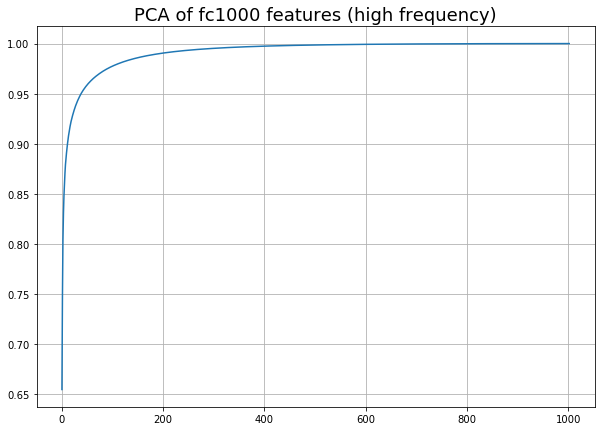

In [33]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features (high frequency)', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [34]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [35]:
n_samples = len(df)
X = normalize(T)
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2')}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ('hinge', 'log'), 'penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [38]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

71.451158512045083

#### Optimal Parameters

In [39]:
classifier.best_params_

{'loss': 'hinge', 'penalty': 'l1'}

## Analyze Iterations at High Frequency and PCA

In [40]:
X = normalize(T)
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5, n_jobs=-1)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_iter': range(1, 10), 'loss': ('hinge', 'log'), 'penalty': ('l1', 'l2', 'none')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [42]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

#### Validation Score

In [43]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

72.218708675904097

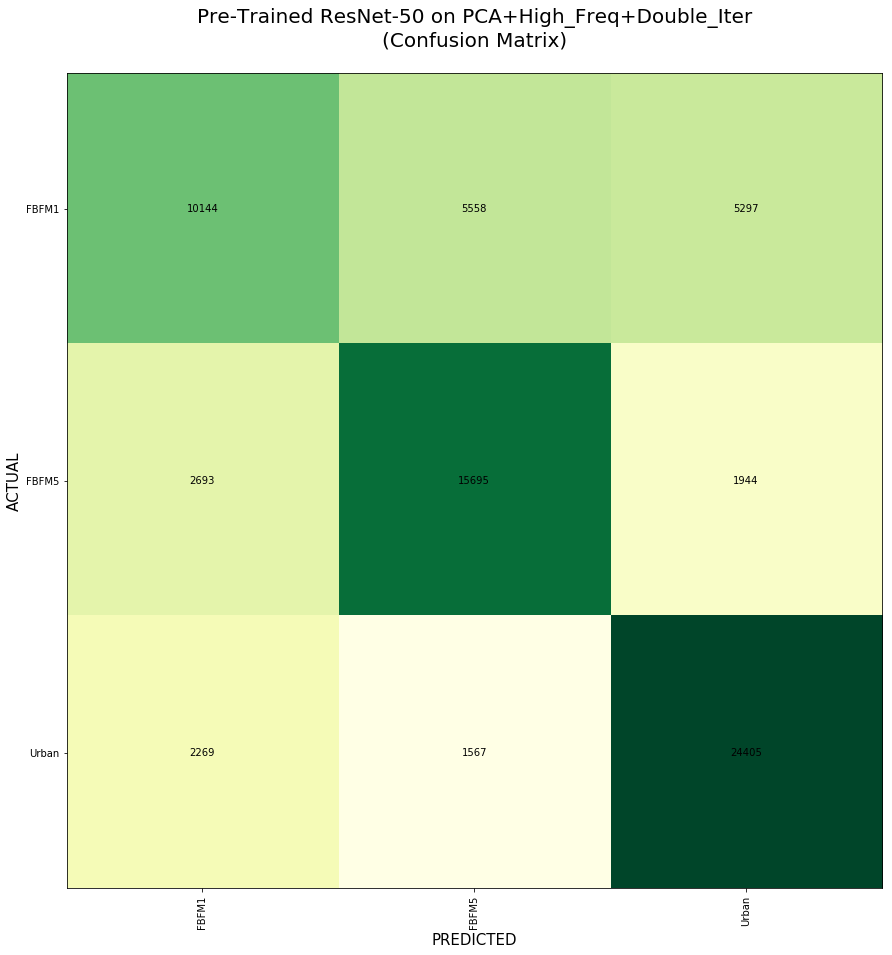

In [44]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA+High_Freq+Double_Iter\n(Confusion Matrix)\n', fontsize=20);

#### Optimal Parameters

In [45]:
classifier.best_params_

{'loss': 'hinge', 'n_iter': 9, 'penalty': 'none'}

# Analyze Iterations at High Frequency without PCA

In [46]:
n_samples = len(df)
X = normalize(image_features[high_class_idx])
y = np.array(labels)[high_class_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5, n_jobs=-1)
classifier.fit(X_train, y_train)

Exception in thread Thread-3131:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.5/multiprocessing/pool.py", line 366, in _handle_workers
    pool._maintain_pool()
  File "/opt/anaconda3/lib/python3.5/multiprocessing/pool.py", line 240, in _maintain_pool
    self._repopulate_pool()
  File "/opt/anaconda3/lib/python3.5/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/opt/anaconda3/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/opt/anaconda3/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
    return Popen(process_obj)
  File "/opt/anaconda3/lib/python3.5/multiprocessing/popen_fork.py", line 20, in __init__
    self._launch(process_obj)
  File "/opt/anacon

In [48]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

#### Validation Score

In [ ]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

In [ ]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on High_Freq+Double_Iter\n(Confusion Matrix)\n', fontsize=20);

#### Optimal Parameters

In [ ]:
classifier.best_params_

# Analyze Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

n_samples = len(df)
X = normalize(image_features[high_class_idx])
y = np.array(labels)[high_class_idx]

clf = SGDClassifier(n_jobs=-1, loss='hinge', n_iter=8, 
                    penalty='none', random_state=0)

train_percent = np.array([0.60,0.70,0.80,0.90,1.])
                         
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, train_sizes=train_percent)    

In [ ]:
train_av = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_av = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_percent*100, train_av, 'bo-', label="Training")
plt.plot(train_percent*100, valid_av, 'go-', label="Validation")
plt.xlabel('% Training',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.axhline(y=train_av[-1], color = 'r', linestyle ='--')
plt.title('Learning Curve',fontsize=16)
plt.legend(fontsize=12)
plt.grid()
print('Optimal Score:\t',train_av[-1])